In [1]:
import os
import sys

import numpy as np

In [2]:
# Convolucion de un kernel sobre una imagen
from scipy.signal import convolve2d, convolve

# Cargar imagen
import cv2

# Tambien para cargar imagen
from skimage import io
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

## Opcional para cargar imagenes
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array


In [3]:
def Conv2D(input_tensor, kernel, stride, print_dims = True):
    
    # Stride: desplazamiento horizontal y vertical
    if isinstance(stride,int):
        sh, sw = stride, stride
    elif isinstance(stride,tuple):
        sh, sw = stride
    
    # Dimensiones del input (height, width)
    n_ah, n_aw = input_tensor.shape
    
    # Dimension del filtro o kernel (nk,nk) SIEMPRE es cuadrado
    n_k  = kernel.shape[0] 
    
    dim_out_h = int(np.floor( (n_ah - n_k) / sh + 1 ))
    dim_out_w = int(np.floor( (n_aw - n_k) / sw + 1 ))
    
    # Inicializar el output
    output = np.zeros([dim_out_h, dim_out_w])
    
    start_row = 0
    for i in range(dim_out_h):
        # Cuando parta una nueva fila, volver a la primera columna
        start_col = 0
        for j in range(dim_out_w):
            
            # Aplicamos la operacion entre tensores
            sub_tensor = input_tensor[start_row:(start_row+n_k), start_col:(start_col+n_k)]
            
            #Actualizar componente del output
            output[i, j] = np.tensordot(sub_tensor , kernel)
            
            #Avanzar stride horizontal
            start_col += sw
            
        # Avanzar stride vertical
        start_row += sh
        
    if print_dims: 
        print("- Input tensor dimensions", input_tensor.shape)
        print("- Kernel dimensions", kernel.shape)
        print("- Stride (h,w) ", (sh, sw))
        print("- Convolved tensor dimension", output.shape)
        
    return output

In [3]:
def MaxPooling2D(input_tensor, size_kernel, stride, print_dims = True):
    
    # Stride: desplazamiento horizontal y vertical
    if isinstance(stride,int):
        sh, sw = stride, stride
    elif isinstance(stride,tuple):
        sh, sw = stride
    
    # Dimensiones del input (height, width)
    n_ah, n_aw = input_tensor.shape
    
    # Dimension del filtro o kernel (nk,nk) SIEMPRE es cuadrado
    n_k  = size_kernel
    
    dim_out_h = int(np.floor( (n_ah - n_k) / sh + 1 ))
    dim_out_w = int(np.floor( (n_aw - n_k) / sw + 1 ))
    
    # Inicializar el output
    output = np.zeros([dim_out_h, dim_out_w])
    
    start_row = 0
    for i in range(dim_out_h):
        start_col = 0
        for j in range(dim_out_w):
            
            # Aplicamos la operacion entre tensores
            sub_tensor = input_tensor[start_row:(start_row+n_k), start_col:(start_col+n_k)]
            #print(sub_tensor)
            output[i, j] = np.max(sub_tensor)
            
            start_col += sw
        start_row += sh
        
    if print_dims: 
        print("- Input tensor dimensions", input_tensor.shape)
        print("- Kernel dimensions", kernel.shape)
        print("- Stride (h,w) ", (sh, sw))
        print("- Convolved tensor dimension", output.shape)
        
    return output

In [46]:
def show_two_plots(img1, img2, title_img1 = 'Original image', title_img2 = 'Convoluted image'):
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.title(title_img1)
    plt.axis('off')
    plt.imshow(img1, cmap='gray')

    plt.subplot(122)
    plt.title(title_img2)
    plt.axis('off')
    plt.imshow(img2, cmap='gray')
    
def show_differences(img, kernel, conv_func = "scipy", stride = None ):
    if conv_func == "own":
        if stride == None:
            stride = 1
        convolved = Conv2D(img, kernel, stride)
    else:
        convolved = convolve2d(img, kernel, mode = "valid")
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.title('Input image')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    
    plt.subplot(122)
    plt.title('Convolved image')
    plt.axis('off')
    plt.imshow(convolved, cmap='gray')
    
    print("Original image dimensions", img.shape)
    print("Kernel dimensions", kernel.shape)
    print("Convolved image dimensions", convolved.shape)
    
    return convolved

Links

1. [KDDNuggets: Understanding deep convolutional neural networks](https://www.kdnuggets.com/2017/11/understanding-deep-convolutional-neural-networks-tensorflow-keras.html)
2. [Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition. ](http://cs231n.github.io/convolutional-networks/)
3. [How will channel RGB effect convolutional neural network? Santhiya Rajan's posts](https://www.researchgate.net/post/How_will_channels_RGB_effect_convolutional_neural_network)
4. [MEDIUM: Convolution operation of a cnn in 5 min](https://medium.com/@sushruth.konapur/convolution-operation-of-a-cnn-in-5-min-91757955835d)
5. [Kernel (image processing) - Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing))

# 0. Introducción

## 0.1 Tensor
El término tensor se utiliza para denorminar a matrices de alta dimensión (usualmente de 3 hacia arriba), pero aplica para todas las dimensiones. Tenemos tensores de una dimensión (vectores), de dos (matrices rectangulares o cuadradas), de tres ("cubos", como las imágenes en RGB), de cuatro (como los vídeos, que son imágenes concatenadas a lo largo de la dimensión definida por el tiempo), etc.

## 0.2 Operaciones en una red convolucional
1. **Convolución**: aplica un filtro sobre una imagen.
2. **Pooling**: comprime la imagen.
3. **Padding:**: agranda la imagen
4. **Aplicación de funciones de activación (como ReLU)**: mapea los pixeles mediante una función. 

___
# 1. Convolución

## 1.1 Definición
La operación convolución es una operación entre dos tensores de iguales dimensiones, y entrega como resultado un escalar, que consiste en multiplicar término a término las componentes de ambos tensores y luego sumar el resultado. Si consideramos dos tensores de dimensiones/tamaño $(3,3)$, la convolución entre ellos estaría dada por

\begin{eqnarray}
    \begin{pmatrix}
    a_{11} & a_{12} & a_{13} \\
    a_{21} & a_{22} & a_{23} \\
    a_{31} & a_{32} & a_{33} 
    \end{pmatrix}
    *
    \begin{pmatrix}
    b_{11} & b_{12} & b_{13} \\
    b_{21} & b_{22} & b_{23} \\
    b_{31} & b_{32} & b_{33} 
    \end{pmatrix}
     &=& \sum_{i = 1}^{3}\sum_{j = 1}^{3} a_{ij}b_{ij} \\
     &=&  a_{11}b_{11} + a_{12}b_{12} + ... + a_{32}b_{32} + a_{33}b_{33}
\end{eqnarray}
donde el resultado es un escalar.

> Formalmente, podemos definir a la operación convolución como la función
> $$*:\mathbb{T} \times \mathbb{T} \to \mathbb{R}, (T_a, T_b) \mapsto T_a*T_b = \sum_{i = 1}^{3}\sum_{j = 1}^{3} a_{ij}b_{ij}$$
> donde
> - $T_a = (a_{ij})$, $T_b = (b_{ij})$ son tensores de la misma dimensión 
> - $\mathbb{T}$ representa al conjunto de todos lo tensores.
> - $\mathbb{R}$ representa al conjunto de los números reales.

___
En una red neuronal convolucional, las imágenes serán guardadas e interpretadas por el modelo como tensores. Por lo que inicialmente, los primeros tensores que veamos serán de dimensiones $(width, height, depth)$ en el caso de imágenes de imágenes en escala de grises (un canal), $depht = 1$, y para imágenes en RGB (u otro de tres canales), $depth = 3$.

**IMPORTANTE**

Por convensión, hay dos formatos en los cuales presentar las imágenes (*esto es importante para cuando definamos los modelos de deep learning*):

- La primera, **channel first**, es cuando el la dimensión del canal va primero que la de la altura y ancho de la imágene (Ej: tensor de dimensiones $(depth,height,width)$.
- La segunda, es la confirguración utilizada por defecto en la explicación anterior, **channel last**, con $(width, height, depth)$.

Antes de entender cómo funciona una red convolucional, debemos tener muy claras las operaciones que se pueden realizar, y cómo éstas afectan las dimensiones del tensor sobre el que se van a aplicar (en palabras simples, ¿Cuál es la salida que se obtiene al aplicar cada una de las operaciones sobre una imagen?)

___
## 1.2 Convolución sobre una imagen

**Conceptos importantes**
* **filtro** (o también llamado kernel) $K$
* **dimensión del filtro** $[n_K]$
* **stride** $[s]$: cantidad de pixeles (horizontal o vertical) que se mueve el filtro al recorrer una imagen
    
<img src="https://cdn-images-1.medium.com/max/1000/1*64Ei_XFsgQoONRzAPI3T_Q.gif">

Recordemos que la operación convolución se aplica entre dos tensores de las mismas dimensiones. ¿Cómo ocurre en una imagen?

1. Se parte desde la esquina superior izquierda del tensor (nuestra imagen de gatito)
2. Se realiza la operación convolución entre el filtro deseado y una porción de la imagen (ambos de mismas dimensiones) y se guarda el resultado en el nuevo tensor resultante
3. Luego se avanza hacia la ***derecha*** $s$ (stride) pixeles, y se vuelve al paso 2 a menos que se llegue hasta el final de la imagen. En tal caso, se avanza al paso 4.
4. Muevo mi ventana horizontalmente hacia la izquierda de la imagen, volviendo a mi posición inicial en la fila, luego me desplazo  hacia ***abajo*** $s$ (stride) pixeles y vuelvo al paso 2, así continuo hasta recorrer la imagen por completo. 

(Pese a que no es realista), pensemos que la imagen del gatito es de $(8,8,1)$, se le está aplicacando un filtro de tamaño $(3,3)$ y cada valor resultante de aplicar la convolución se va guardando en un nuevo tensor, esta vez de dimensiones $(6,6,1)$. ¿Cuál es la relación entre los las dimensiones del kernel ($n_K$), las dimensiones de la imagen $(8,8)=(n_A,n_A)$ y el stride $s$?

$$\Bigg\lfloor \dfrac{n_A- n_K}{s} + 1 \Bigg\rfloor $$

la parte entera inferior de esas operaciones. 

**OBSERVACIONES**
* Note que da igual el orden en el que realice las operaciones de convolución (en nuestro caso hacia la derecha y luego abajo), pues todas son independientes (esto permite paralelizar las operaciones y abre la posibilidad de hacer más eficiente los cálculos)
* En el caso en el que la imagen de entrada no sea cuadrada $(n_AH,n_AW)$, las dimensiones horizontal y vertical del output se pueden calcular utilizando la misma ecuación anterior, tomando de manera independiente las dimensiones vertical $n_{AH}$ y horizontal $n_{AW}$ con sus respectivos strides (los que pueden ser distintos)

### Ejemplo práctico

Vamos a cargar una imagen y a ver distintos filtros aplicados a ella, también vamos a analizar las dimensiones de los filtros, la imagen inicial (a la que se le aplica el filtro) y la imagen resultante (después de aplicado el filtro) 

**Cargar imagen**

Las imagenes con las que estamos trabajando están en `RGB`, sin embargo, la librería que estamos ocupando, [`OpenCV`, carga las imágenes en formato `BGR` (¿Por qué?)](https://www.learnopencv.com/why-does-opencv-use-bgr-color-format/), por lo que obtendremos sus versiones en `RGB` y `GRAYSCALE` para trabajar con ellas

In [5]:
# Cargamos imagen
#filename = "./files/cat.png"
filename = "./files/chimu2.png"
#filename = "./files/image3.png"
img_bgr = cv2.imread(filename, cv2.IMREAD_COLOR)

# Image to RGB: Por defecto, cv2 carga las imagenes en formato BGR (las imagenes que tenemos en el directorio local estan en RGB)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Image to GRAY: La convertimos a escala de grises
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

In [6]:
print("Dimension RGB ", img_rgb.shape )
print("Dimension Gray ", img_gray.shape)

Dimension RGB  (1024, 768, 3)
Dimension Gray  (1024, 768)


Notemos que la imagen en escala de grises tiene ahora un solo canal, pues tiene dimensiones `(243,600)`. Una observación importante respecto a esta parte: 

cuando trabajemos imágenes en escala de grises con nuestros modelos de deep learning, tenemos que asegurarnos de que la dimensión de profundidad de la imagen (1 en escala de grises, 3 en RGB) esté  explicita en el tensor. En el caso de esta imagen, tendríamos que reescalarla a `(243,600,1)`. Nada cambia en la imagen, sólo el tipo de tensor en el que la guardamos.


**Visualizamos varios formatos de la imagen**

Trabajaremos con una imagen de un gatito que está en la carpeta `./files/cat2.png`

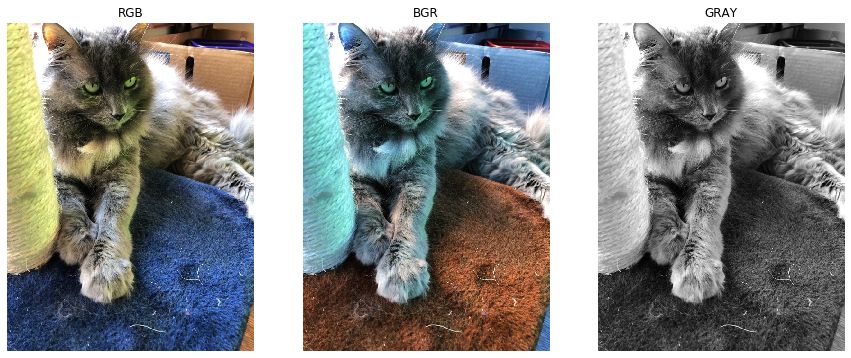

In [7]:
fig = plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title('RGB')
plt.axis('off')
plt.imshow(img_rgb, cmap='gray')

plt.subplot(132)
plt.title('BGR')
plt.axis('off')
plt.imshow(img_bgr, cmap='gray')

plt.subplot(133)
plt.title('GRAY')
plt.axis('off')
plt.imshow(img_gray, cmap='gray')

### 1.2.0 Algunos filtros
Puede revisar una lista de los filtros/kernel más comunes en [Kernel (image processing) - Wikipedia](https://en.wikipedia.org/wiki/Kernel_(image_processing))

Vamos a utilizar la función `show_differences()` para aplicar un `kernel` sobre nuestra imagen en escala de grises (al tensor `img_gray`)



___
* **Edge detection**: considerando un filtro K
$$
K = 
\begin{bmatrix}
-1 &  -1 & -1 \\
-1 & \ \ 8 & -1 \\
-1 &  -1 & -1
\end{bmatrix}
$$

In [8]:
# Defino el filtro para Edge Detection
kernel = np.array([[-1. , -1. , -1.],
                   [-1. ,  8. , -1.],
                   [-1. , -1. , -1.]], np.float32)

Original image dimensions (1024, 768)
Kernel dimensions (3, 3)
Convolved image dimensions (1022, 766)
Wall time: 57.8 ms


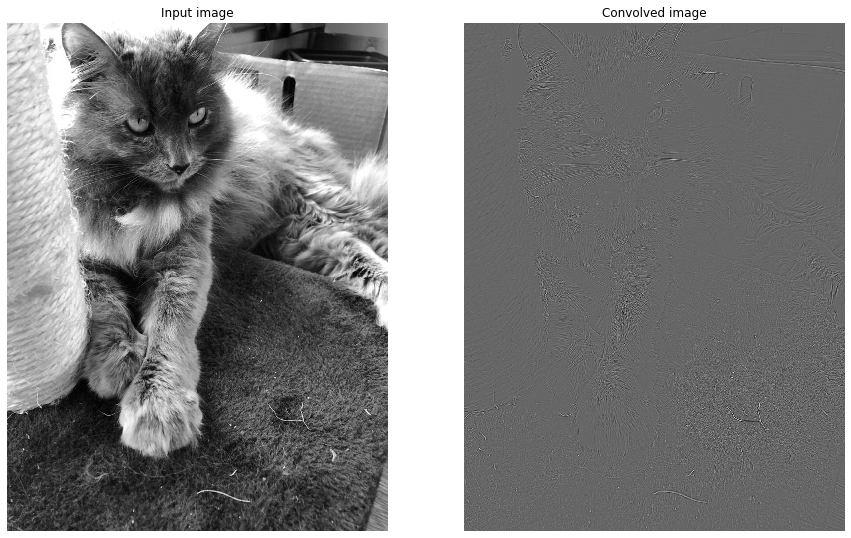

In [11]:
%%time
# Con la función convolve de scipy
conv_gray = show_differences(img_gray, kernel)

- Input tensor dimensions (1024, 768)
- Kernel dimensions (3, 3)
- Stride (h,w)  (1, 1)
- Convolved tensor dimension (1022, 766)
Original image dimensions (1024, 768)
Kernel dimensions (3, 3)
Convolved image dimensions (1022, 766)
Wall time: 11.9 s


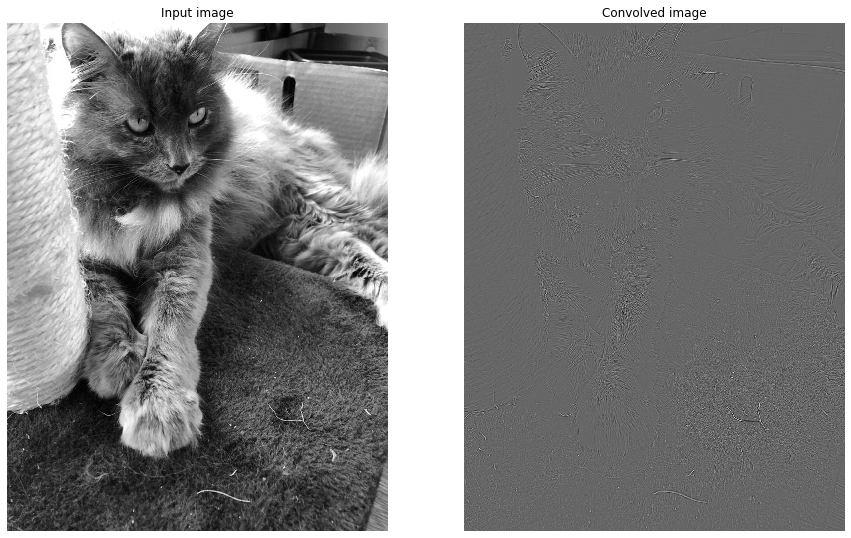

In [12]:
%%time
# Con la funcion "naive" creada por nosotros
conv_gray2 = show_differences(img_gray,kernel, "own", 1)

En este caso, tenemos: 
- $s = 1$
- $n_{AH} = 1024$
- $n_{AW} = 768$
- $n_K = 3$

con lo que obtenemos: 

* Para las columnas (width)
$$\Bigg\lfloor \dfrac{n_{AW}- n_K}{s} + 1 \Bigg\rfloor  = \Bigg\lfloor \dfrac{1024- 3}{1} + 1 \Bigg\rfloor = 1022 $$

* Para las filas (height)
$$\Bigg\lfloor \dfrac{n_{AH}- n_K}{s} + 1 \Bigg\rfloor  = \Bigg\lfloor \dfrac{768- 3}{1} + 1 \Bigg\rfloor = 766$$

lo cual coincide con las salidas obtenidas.

___
___
* **Identity**: considerando un filtro K
$$
K = 
\begin{bmatrix}
0 &  0 & 0 \\
0 &  1 & 0 \\
0 &  0 & 0
\end{bmatrix}
$$

In [13]:
# Defino el filtro para Identity
kernel = np.array([[0. , 0. , 0.],
                   [0. ,  1. , 0.],
                   [0. , 0. , 0.]], np.float32)

- Input tensor dimensions (1024, 768)
- Kernel dimensions (3, 3)
- Stride (h,w)  (1, 1)
- Convolved tensor dimension (1022, 766)
Original image dimensions (1024, 768)
Kernel dimensions (3, 3)
Convolved image dimensions (1022, 766)
Wall time: 12 s


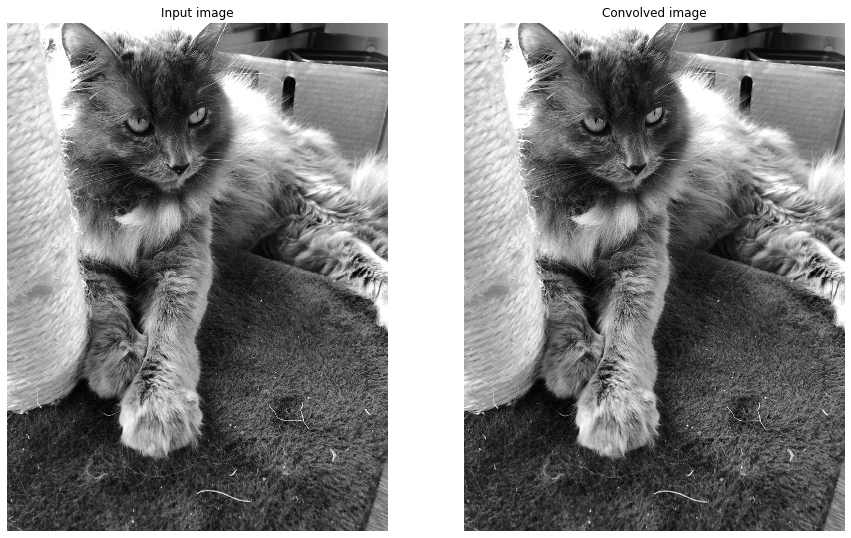

In [14]:
%%time
# Con nuestra funcion
conv_gray = show_differences(img_gray, kernel, "own",1)

Original image dimensions (1024, 768)
Kernel dimensions (3, 3)
Convolved image dimensions (1022, 766)
Wall time: 52.8 ms


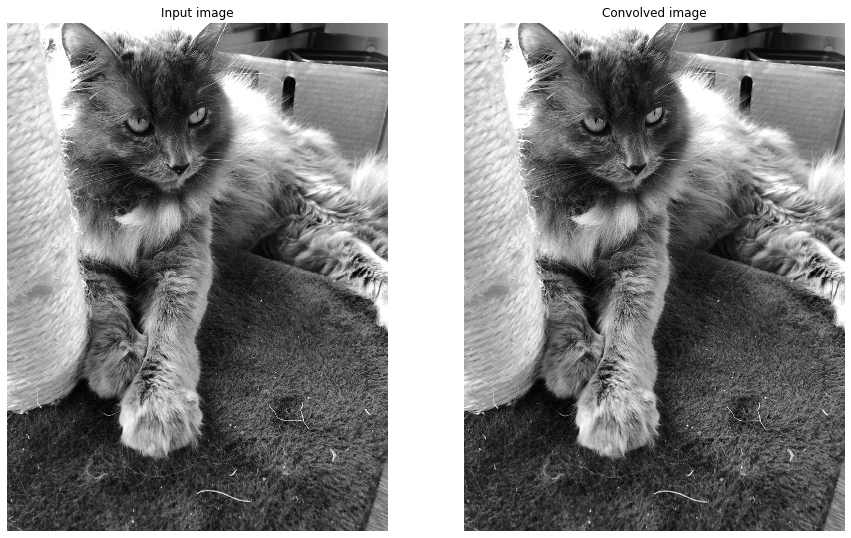

In [15]:
%%time
# Con la de scipy
conv_gray = show_differences(img_gray, kernel)

___
___
* **Blur**: considerando un filtro K
$$
K = 
\dfrac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$

**De tamaño 3**

Filter blur shape (3, 3) 

Original image dimensions (1024, 768)
Kernel dimensions (3, 3)
Convolved image dimensions (1022, 766)


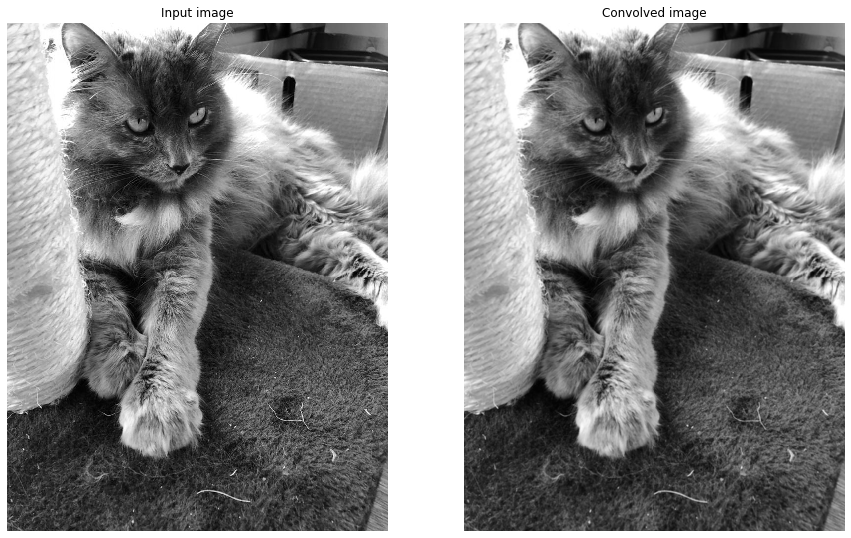

In [16]:
# Defino el filtro blur de (3,3)
n = 3
blur = np.ones((n,n), np.float32) / n**2.
print("Filter blur shape {} \n".format(blur.shape) )

conv_blur = show_differences(img_gray, blur)

**De tamaño 8**

Filter blur shape (8, 8) 

Original image dimensions (1024, 768)
Kernel dimensions (8, 8)
Convolved image dimensions (1017, 761)


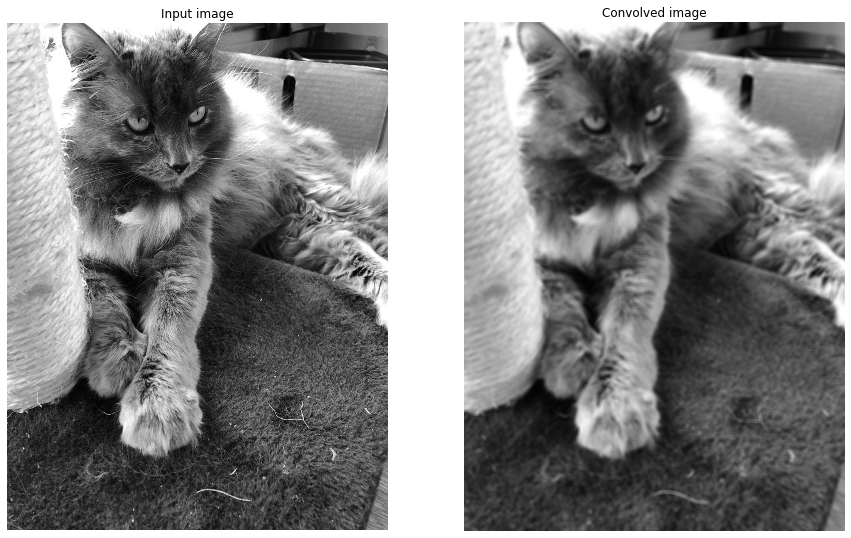

In [17]:
# Defino el filtro blur de (8,8)
n = 8
blur = np.ones((n,n), np.float32) / n**2.
print("Filter blur shape {} \n".format(blur.shape) )

conv_blur = show_differences(img_gray, blur)

**De tamaño 16**

Filter blur shape (16, 16) 

Original image dimensions (1024, 768)
Kernel dimensions (16, 16)
Convolved image dimensions (1009, 753)


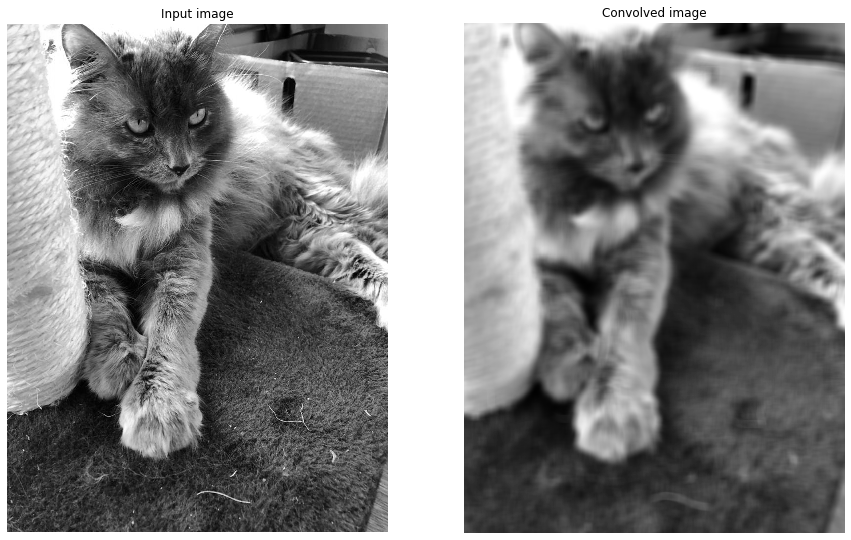

In [18]:
# Defino el filtro blur de (16,16)
n = 16
blur = np.ones((n,n), np.float32) / n**2.
print("Filter blur shape {} \n".format(blur.shape) )

conv_blur = show_differences(img_gray, blur)

___
### 1.2.1 Uniendo Kernels
La operación convolución es un operador lineal, eso quiere decir que combinaciones lineales de dos convoluciones sobre un mismo objeto son también una convolución. Por lo tanto, veamos cómo queda esto: 

**Vertical Edge**

In [19]:
kernel = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], np.float32)

Original image dimensions (1024, 768)
Kernel dimensions (3, 3)
Convolved image dimensions (1022, 766)
Wall time: 50 ms


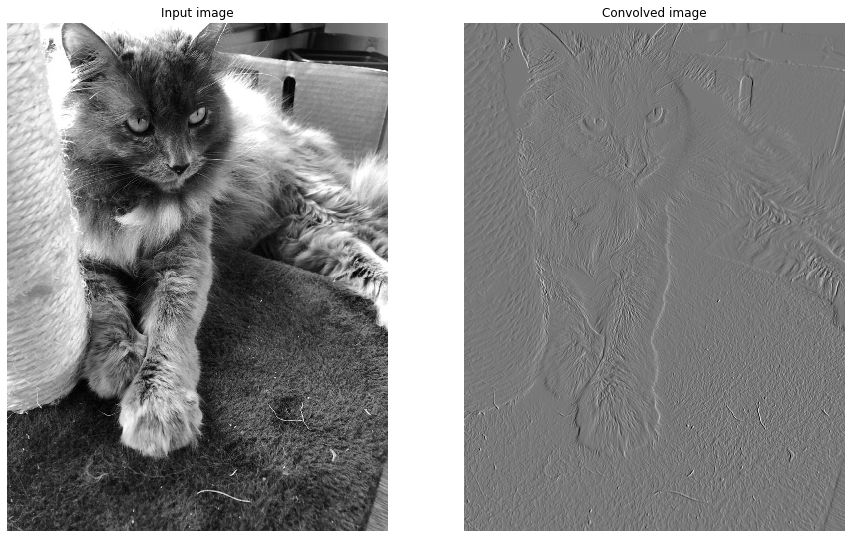

In [20]:
%%time
conv_dy = show_differences(img_gray, kernel)

Original image dimensions (1024, 768)
Kernel dimensions (3, 3)
Convolved image dimensions (1022, 766)
Wall time: 51.6 ms


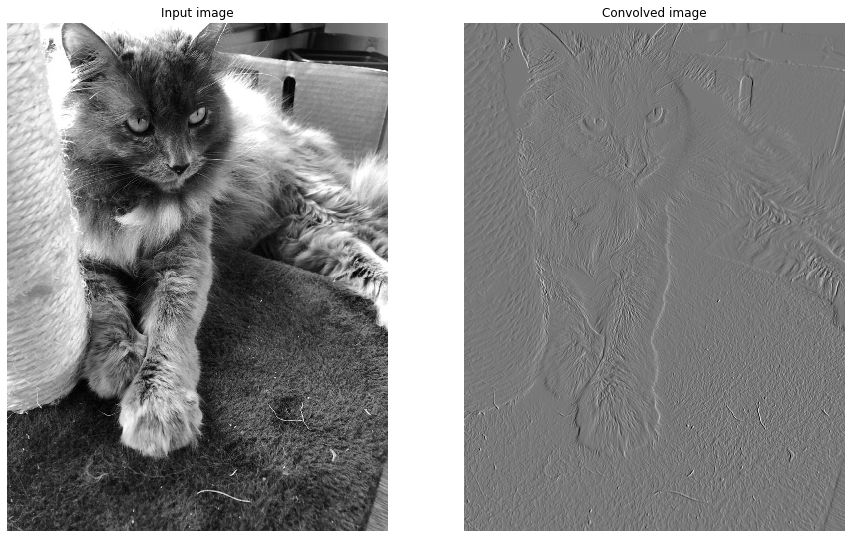

In [21]:
%%time
conv_dy = show_differences(img_gray, kernel, "scipy",1)

___
**Horizontal Edge**

In [22]:
kernel = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], np.float32)

Original image dimensions (1024, 768)
Kernel dimensions (3, 3)
Convolved image dimensions (1022, 766)
Wall time: 51.4 ms


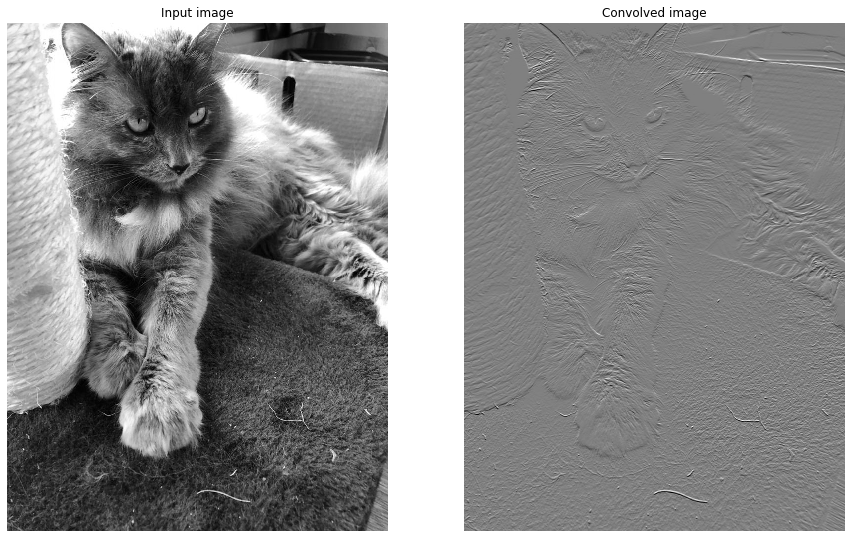

In [23]:
%%time
conv_dx = show_differences(img_gray,kernel)

Tenemos que: 

+ Horizontalmente, estamos aplicando filtros de dimensión $3$ con un stride de $1$, por lo tanto, la salida de mi imagen tendrá 
___
## 1.2.1 Combinando los Kernels

Los dos filtros anteriores son operadores gradientes. Ellos permiten, en cierto sentido, revelar una cierta estructura en una dirección $d$.


**Por ejemplo, considerando** $$K_d = \sqrt{K_x^2 + K_y^2}$$


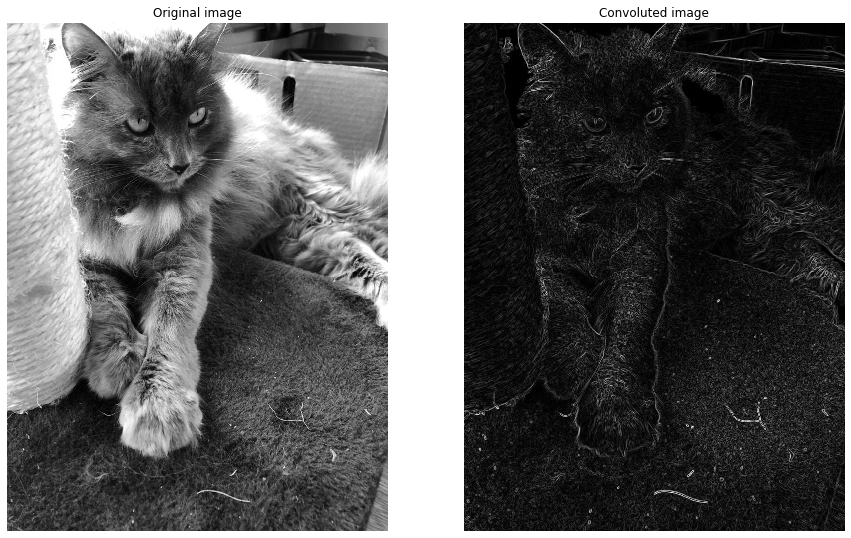

In [24]:
mag = np.hypot(conv_dx, conv_dy)  # magnitude
mag *= 255.0 / np.max(mag)  # normalize (Q&D)
show_two_plots(img_gray, mag)

___
**Ahora una combinación lineal de ellos:**

$$K_l = 0.5*K_x + 0.5*K_y$$


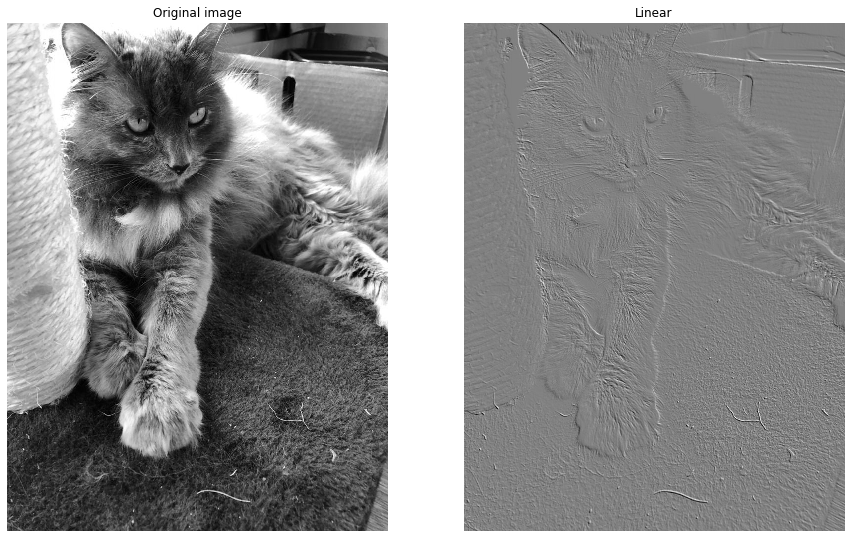

In [25]:
lin = .5*(conv_dx + conv_dy)
#lin *= 255.0 / np.max(lin)  # normalize (Q&D)
show_two_plots(img_gray, lin, title_img2 = 'Linear')

___
**Otra combinación lineal, pero de los tres:**

$$K_l = 0.3 K_x + 0.3 K_y + 0.4 mag$$

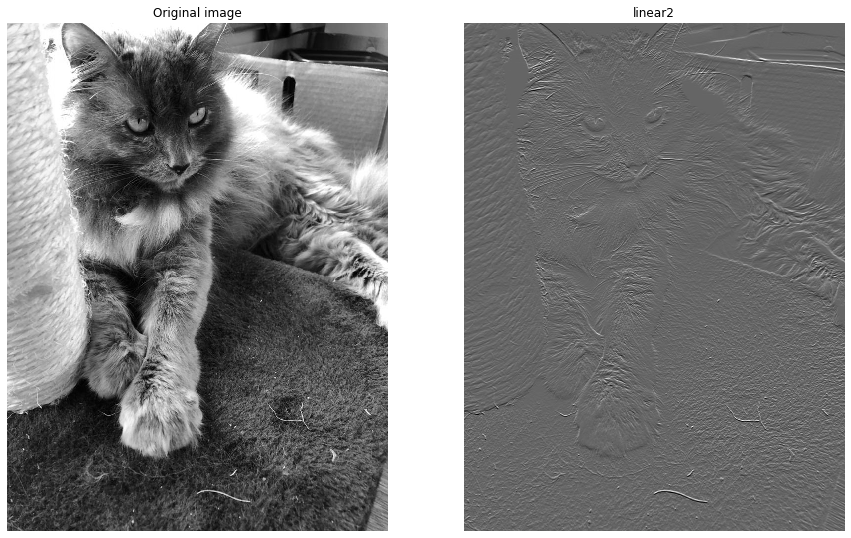

In [26]:
lin2 = (0.3*conv_dx + 0.3*conv_dx + 0.4*mag)
show_two_plots(img_gray, lin2, title_img2 = 'linear2')

### 1.2.2 Aplicando varios kernels de manera sucesiva 

Imagen Original -> Kernel1 -> Imagen Convolucion 1

Imagen Convolucion 1  -> Kernel2 -> Imagen Convolucion 2

Imagen Convolucion 2 -> Kernel3 -> Imagen Convolucion 3

Vamos a imprimir las dimensiones de las capas de salida para que verifique en cada caso que se cumple: 

$$\Bigg\lfloor \dfrac{n_A- n_K}{s} + 1 \Bigg\rfloor $$

para cada dimensión de la imagen.

In [47]:
print("CAPA -- (row, col)")
print("Input -- ",img_gray.shape)
new_img = Conv2D(img_gray, kernel, stride = 5, print_dims = False)
print("Output Conv1/Input Conv2 -- ",new_img.shape)
new_img = Conv2D(new_img, kernel, stride = 5, print_dims = False)
print("Output Conv2/Input Conv3 -- ",new_img.shape)
new_img = Conv2D(new_img, kernel, stride = 5, print_dims = False)
print("Output Conv3 -- ",new_img.shape)

CAPA -- (row, col)
Input --  (1024, 768)
Output Conv1/Input Conv2 --  (205, 154)
Output Conv2/Input Conv3 --  (41, 31)
Output Conv3 --  (8, 6)


**OBSERVACION**

En términos simples, las ***redes convolucionales*** se componen de ***capas convolucionales***. Estas capas contienen filtros/kernels que son aplicados al tensor de entrada. En nuestro ejemplo anterior: 

<h4><center>Dimensiones y Parámetros</center></h4>

| CAPA | INPUT | FILTRO | STRIDE | OUTPUT 
| --- | --- | --- | --- | --- |
| Primera | (1024,768) | (3,3) | 5 | (205, 154)
| Segunda | (205,154) | (3,3) | 5 | (41, 31)
| Tercera | (41,31) | (3,3) | 5 | (8, 6)
 
compruebe, para cada dimensión, si se cumple $$\Bigg\lfloor \dfrac{n_A- n_K}{s} + 1 \Bigg\rfloor $$

In [31]:
img_gray.shape

(1024, 768)

# 2. Pooling
Es una operación que opera de la misma forma que la convolución, recibe dos tensores de una misma dimensión resumiendo dicha información. Las dos formas más usuales de resumirla son mediante un: 
- MaxPooling: quedándose con el máximo de los valores en dicha ventana.
- MeanPooling: quedándose con el promedio de los valores en esa ventana.

| ![max_pooling.png](https://www.kdnuggets.com/wp-content/uploads/max_pooling.png) | 
|:--:| 
| *Ilustración de MaxPooling, [Fuente: KDDNugets](https://www.kdnuggets.com/wp-content/uploads/max_pooling.png)* |

Tal como es esperable, al aplicarlo sobre una imágenen ocurre lo mismo que con la convolución, la operación Pooling mapea dos tensores de igual dimensión a un escalar.

>```python
>s = "Python syntax highlighting"
>print s
>```

In [ ]:
from skimage.measure import block_reduce
def MaxPooling2D(input_tensor, stride):
    block_reduce(input_tensor, kernel_shape, )

In [ ]:
N = 4

input_tensor = np.zeros((N,N))
horizontal = False 
input_tensor[0,0] = 1
input_tensor[N-1,N-1] = 1

#if horizontal: 
#    for i in range(input_tensor.shape[0]):    
#        input_tensor[i,:] = float(i)
#else:
#    for j in range(input_tensor.shape[1]):    
#        input_tensor[:,j] = float(j)

input_tensor

In [ ]:
kernel = np.array([[1., 1., 1.],
                   [1., 1., 1.],
                   [1., 1., 1.]], np.float32)
kernel = np.array([[0., 1.],
                   [1., 0.]], np.float32)
stride = 2

In [ ]:
#Conv2d(input_tensor, kernel, stride)

In [ ]:
def Conv2d(input_tensor, kernel, stride, print_dims = True):
    
    # Stride: desplazamiento horizontal y vertical
    if isinstance(stride,int):
        sh, sw = stride, stride
    elif isinstance(stride,tuple):
        sh, sw = stride
    
    # Dimensiones del input (height, width)
    n_ah, n_aw = input_tensor.shape
    
    # Dimension del filtro o kernel (nk,nk) SIEMPRE es cuadrado
    n_k  = kernel.shape[0] 
    
    dim_out_h = int(np.floor( (n_ah - n_k) / sh + 1 ))
    dim_out_w = int(np.floor( (n_aw - n_k) / sw + 1 ))
    
    # Inicializar el output
    output = np.zeros([dim_out_h, dim_out_w])
    
    start_row = 0
    for i in range(dim_out_h):
        start_col = 0
        for j in range(dim_out_w):
            
            # Aplicamos la operacion entre tensores
            sub_tensor = input_tensor[start_row:(start_row+n_k), start_col:(start_col+n_k)]
            #print(sub_tensor)
            output[i, j] = np.tensordot(sub_tensor , kernel)
            
            start_col += sw
        start_row += sh
        
    if print_dims: 
        print("- Input tensor dimensions", input_tensor.shape)
        print("- Kernel dimensions", kernel.shape)
        print("- Stride (h,w) ", (sh, sw))
        print("- Convolved tensor dimension", output.shape)
        
    return output

In [ ]:
Conv2d(input_tensor, kernel, stride)

In [ ]:
MaxPooling2D(input_tensor, 2,2)

In [35]:
1021/5

204.2